In [1]:
# Importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from imblearn.under_sampling import RandomUnderSampler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.probability import FreqDist
from tabulate import tabulate

import nltk
import string
import warnings
warnings.filterwarnings('ignore')

In [2]:
! pip install WordCloud

In [3]:
# Load the datset
df = pd.read_csv("Restaurant reviews.csv")

In [4]:
# View the first 5 rows of the data
df.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN


In [5]:
# Check datatset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Restaurant  10000 non-null  object 
 1   Reviewer    9962 non-null   object 
 2   Review      9955 non-null   object 
 3   Rating      9962 non-null   object 
 4   Metadata    9962 non-null   object 
 5   Time        9962 non-null   object 
 6   Pictures    10000 non-null  int64  
 7   7514        1 non-null      float64
dtypes: float64(1), int64(1), object(6)
memory usage: 625.1+ KB


In [6]:
# delete column '7514' as it has only one non-null value

df.drop(["7514"], axis=1, inplace=True)

In [7]:
# Check duplicate data

print((df.duplicated().sum()))

36


In [8]:
# Delete duplicate data

df.drop_duplicates(inplace = True)

In [9]:
# Null Data
df.isna().sum()

Restaurant    0
Reviewer      2
Review        9
Rating        2
Metadata      2
Time          2
Pictures      0
dtype: int64

In [10]:
# Let's exclude null values.
df = df.dropna()

In [11]:
# Check the unique values and frequency for 'Rating'

df['Rating'].value_counts()

5       3826
4       2373
1       1735
3       1192
2        684
4.5       69
3.5       47
2.5       19
1.5        9
Like       1
Name: Rating, dtype: int64

In [12]:
# # Replace string "Like' with '5' as it is the most frequent value in the Rating column.

df['Rating'] = df['Rating'].replace(['Like'], '5')

In [13]:
# Replace column type 'Rating' to 'float'.

df['Rating'] = df['Rating'].astype(float)

In [14]:
# Check the unique values and frequency for 'Rating'

df['Rating'].value_counts()

5.0    3827
4.0    2373
1.0    1735
3.0    1192
2.0     684
4.5      69
3.5      47
2.5      19
1.5       9
Name: Rating, dtype: int64

In [15]:
# Create a copy of the dataset with only columns Review and Rating 
df=df[['Review','Rating']].copy()

# Rename columns
df = df.rename(columns={'Review': 'text', 'Rating': 'text_label'})
df

,text,text_label
0,"The ambience was good, food was quite good . h...",5.0
1,Ambience is too good for a pleasant evening. S...,5.0
2,A must try.. great food great ambience. Thnx f...,5.0
3,Soumen das and Arun was a great guy. Only beca...,5.0
4,Food is good.we ordered Kodi drumsticks and ba...,5.0
...,...,...
9995,Madhumathi Mahajan Well to start with nice cou...,3.0
9996,This place has never disappointed us.. The foo...,4.5
9997,"Bad rating is mainly because of ""Chicken Bone ...",1.5
9998,I personally love and prefer Chinese Food. Had...,4.0


In [16]:
print("\n All Data Labels")
print(df.groupby("text_label").count())


 All Data Labels
            text
text_label      
1.0         1735
1.5            9
2.0          684
2.5           19
3.0         1192
3.5           47
4.0         2373
4.5           69
5.0         3827


In [17]:
# Tokenization and word cleaning
# Download NLTK stopwords
nltk.download('stopwords')
nltk.download('punkt')

# Lets now create a function to apply all of our data preprocessing steps which we can then use on a corpus

def preprocess_text(text):
    tokenized_document = nltk.tokenize.RegexpTokenizer('[a-zA-Z0-9\']+').tokenize(text) # Tokenize
    cleaned_tokens = [word.lower() for word in tokenized_document if word.lower() not in stop_words] # Remove
    stemmed_text = [nltk.stem.PorterStemmer().stem(word) for word in cleaned_tokens]
    return stemmed_text

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    return ' '.join(tokens)

# Clean text
def clean_text(text):
    text = text.lower()  # Convert text to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = ' '.join(text.split())  # Remove extra whitespaces
    return text

# Preprocess text data
df['preprocessed_text'] = df['text'].apply(preprocess_text)

df['clean_text'] = df['text'].apply(clean_text)

# Tokenization
df['tokens'] = df['clean_text'].apply(word_tokenize)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\harko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
df['text'] = df['text'].apply(preprocess_text)

In [19]:
# Calculate the class array
# Apply CountVectorizer on preprocessed text
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['preprocessed_text'])
X = pd.DataFrame(X.toarray())
X.head()

,0,1,2,3,4,5,6,7,8,9,...,14241,14242,14243,14244,14245,14246,14247,14248,14249,14250
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Labelling the class label
# This function returns sentiment value based on:
# text label <= 3.0 -> Negative
# text label > 3.0 -> Positive


def conv(row):
    
    if row['text_label'] <= 3.0:
        val = 'Negative'
    else: 
        val = 'Positive'
    
    return val

# Applying the function in our dataset
df['text_label'] = df.apply(conv, axis=1)

In [21]:
# Splitting and balancing the data

y= df['text_label']

X_train, X_test, y_train, y_test = train_test_split(
X, y, train_size=0.8,test_size=0.2,random_state=99)

<Axes: xlabel='text_label', ylabel='count'>

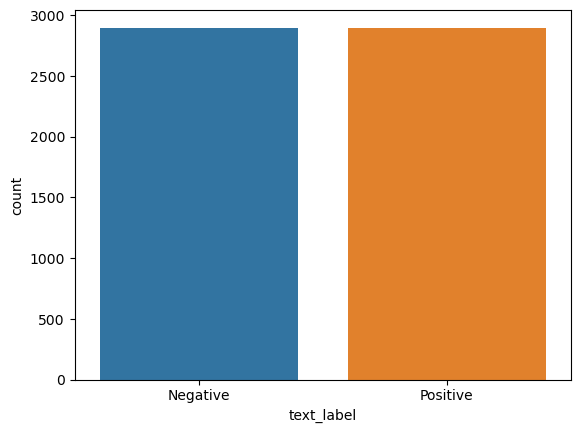

In [22]:
resampler = RandomUnderSampler(random_state=0)
X_train_undersampled, y_train_undersampled = resampler.fit_resample(X_train, y_train)

sns.countplot(x=y_train_undersampled)

In [23]:
# Modelling the data
model = MultinomialNB()
model.fit(X_train_undersampled, y_train_undersampled)

MultinomialNB()

In [24]:
y_pred = model.predict(X_test)

# Computing the accuracy and Making the Confusion Matrix
acc=metrics.accuracy_score(y_test,y_pred)
print('accuracy:%.2f\n\n'%(acc))
cm = metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm, '\n\n')
print('.......................................................')
result = metrics.classification_report(y_test, y_pred)
print("Classification Report:\n",)
print(result)

accuracy:0.84


Confusion Matrix
[[ 595  145]
 [ 180 1071]] 


.......................................................
Classification Report:

              precision    recall  f1-score   support

    Negative       0.77      0.80      0.79       740
    Positive       0.88      0.86      0.87      1251

    accuracy                           0.84      1991
   macro avg       0.82      0.83      0.83      1991
weighted avg       0.84      0.84      0.84      1991



In [25]:
# Performing Sentiment analysis
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment_scores(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['pos'], sentiment['neg'], sentiment['neu'], sentiment['compound']

# Apply sentiment analysis to each text
df['positive'], df['negative'], df['neutral'], df['compound'] = zip(*df['clean_text'].map(get_sentiment_scores))

print("Sample of Sentiment Scores:")
print(df[['positive', 'negative', 'neutral', 'compound']].head())

Sample of Sentiment Scores:
   positive  negative  neutral  compound
0     0.418       0.0    0.582    0.9664
1     0.446       0.0    0.554    0.9360
2     0.316       0.0    0.684    0.9186
3     0.292       0.0    0.708    0.8591
4     0.391       0.0    0.609    0.9201


In [26]:
# Calculate summary statistics
summary_stats = df[['positive', 'negative', 'neutral', 'compound']].describe()

# Print summary statistics
print("Summary Statistics:")
print(summary_stats)

Summary Statistics:
          positive     negative      neutral     compound
count  9955.000000  9955.000000  9955.000000  9955.000000
mean      0.253180     0.056102     0.688505     0.474117
std       0.233832     0.112885     0.219711     0.583696
min       0.000000     0.000000     0.000000    -0.994200
25%       0.090000     0.000000     0.621000     0.000000
50%       0.208000     0.000000     0.731000     0.764800
75%       0.344000     0.070000     0.820000     0.934900
max       1.000000     1.000000     1.000000     0.999600


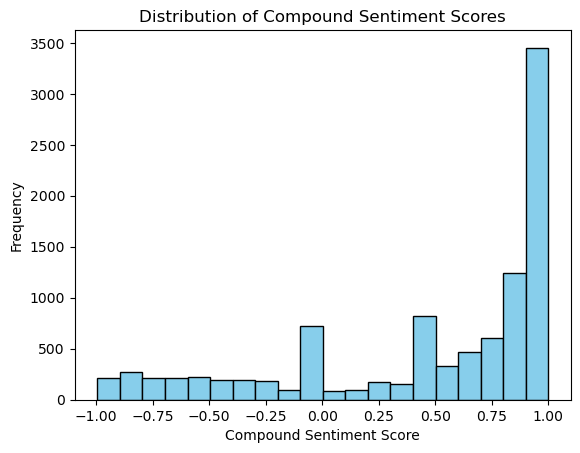

In [27]:
# Plot histogram of compound sentiment scores
plt.hist(df['compound'], bins=20, color='skyblue', edgecolor='black')  # Adjust color if needed
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Compound Sentiment Scores')
plt.show()

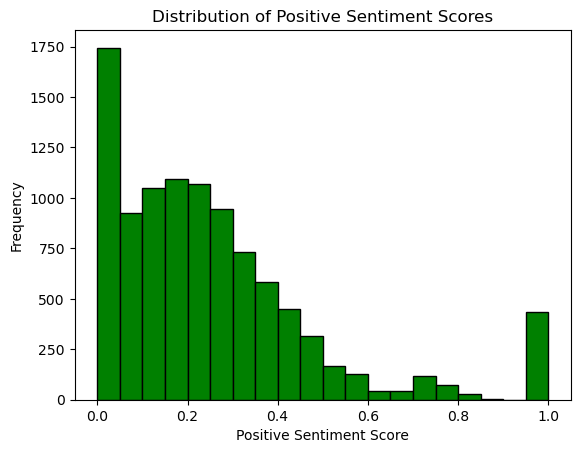

In [28]:
# Plot histogram of positive sentiment scores
plt.hist(df['positive'], bins=20, color='green', edgecolor='black')  # Adjust color if needed
plt.xlabel('Positive Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Positive Sentiment Scores')
plt.show()

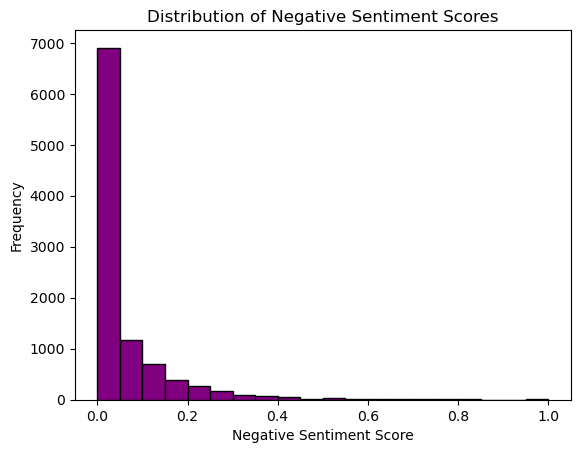

In [29]:
# Plot histogram of negative sentiment scores
plt.hist(df['negative'], bins=20, color='purple', edgecolor='black')  # Adjust color if needed
plt.xlabel('Negative Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Negative Sentiment Scores')
plt.show()

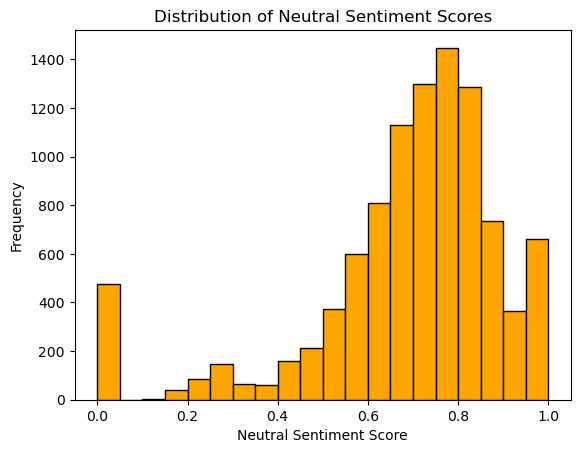

In [30]:
# Plot histogram of neutral sentiment scores
plt.hist(df['neutral'], bins=20, color='orange', edgecolor='black')  # Adjust color if needed
plt.xlabel('Neutral Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Neutral Sentiment Scores')
plt.show()

In [31]:
# Percentage of positive reviews
# Count the number of reviews with a compound score above the threshold
positive_reviews_count = df[df['compound'] > 0].shape[0]

# Total number of reviews
total_reviews = df.shape[0]

# Calculate percentage of positive reviews
percentage_positive = (positive_reviews_count / total_reviews) * 100

print(f"Percentage of Positive Reviews: {percentage_positive:.2f}%")

Percentage of Positive Reviews: 74.66%


In [32]:
# Percentage of negative reviews
# Count the number of reviews with a compound score above the threshold
negative_reviews_count = df[df['compound'] < 0].shape[0]

# Total number of reviews
total_reviews = df.shape[0]

# Calculate percentage of negative reviews
percentage_negative = (negative_reviews_count / total_reviews) * 100

print(f"Percentage of Negative Reviews: {percentage_negative:.2f}%")

Percentage of Negative Reviews: 18.79%


In [33]:
# Tokenize words for positive and negative sentiments
positive_words = ' '.join(df[df['compound'] > 0]['clean_text'])
negative_words = ' '.join(df[df['compound'] < 0]['clean_text'])
all_words = ' '.join(df['clean_text'])

# Tokenize all words
tokens_positive = word_tokenize(positive_words)
tokens_negative = word_tokenize(negative_words)
tokens_all = word_tokenize(all_words)

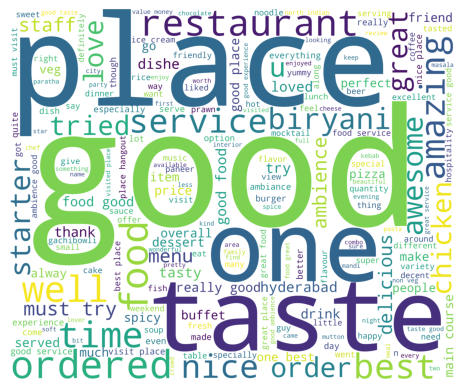

In [34]:
# WordCloud - Sentiment Positive

df1 = df[df['text_label']== 'Positive']
words = ' '.join(df1['text'].astype(str))
cleaned_word = ' '.join([word for word in words.split() if not word.startswith('@')])

wordcloud = WordCloud(background_color='white',stopwords=STOPWORDS,
                      width=3000, height=2500).generate(''.join(cleaned_word))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

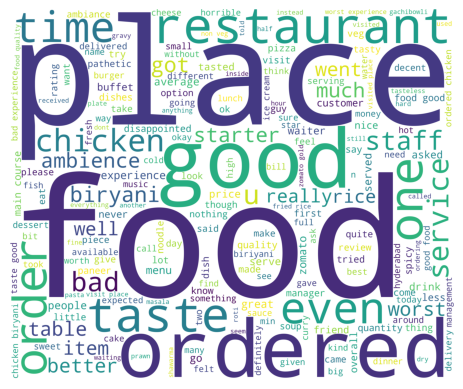

In [35]:
# WordCloud - Sentiment Negative

df2 = df[df['text_label']=='Negative']
words = ' '.join(df2['text'].astype(str))
cleaned_word = ' '.join([word for word in words.split() if not word.startswith('@')])

wordcloud = WordCloud(background_color='white',stopwords=STOPWORDS,
                      width=3000, height=2500).generate(''.join(cleaned_word))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [36]:
# Calculate frequency distributions
freq_dist_positive = FreqDist(tokens_positive)
freq_dist_negative = FreqDist(tokens_negative)
freq_dist_all = FreqDist(tokens_all)

  the   and     a   was    to    is  good    of     i   for 
19087 14871  8344  8222  7906  7761  6415  6152  5546  5448 


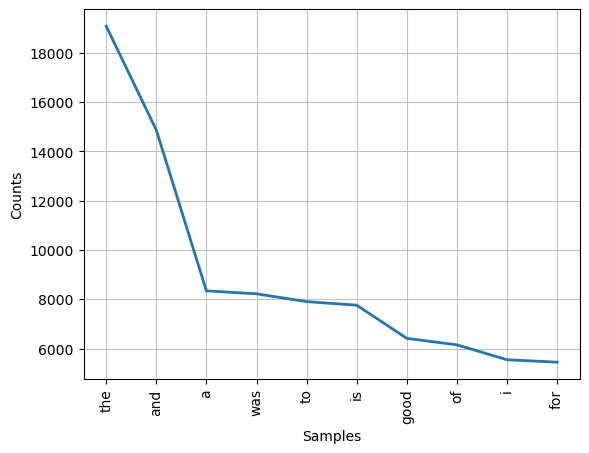

<Axes: xlabel='Samples', ylabel='Counts'>

In [37]:
# Analysis the positive words
freq_dist_positive.tabulate(10)
freq_dist_positive.plot(10)

 the  and  was   to    i  not   is    a   of   it 
3760 2549 1931 1882 1795 1470 1370 1283 1217 1115 


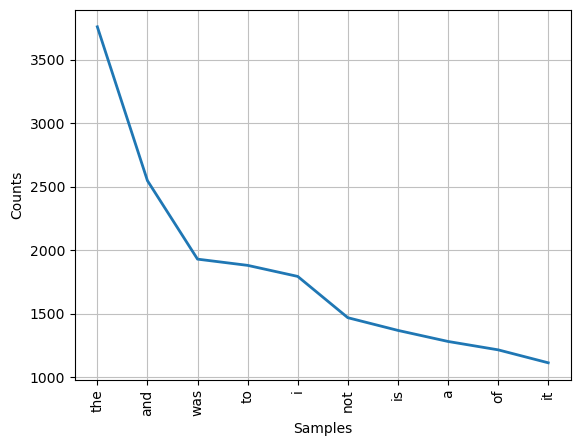

<Axes: xlabel='Samples', ylabel='Counts'>

In [38]:
# Analysis the negative words
freq_dist_negative.tabulate(10)
freq_dist_negative.plot(10)